In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
base_path = "/Users/sayan/CMB_WORK/Maps/"

cl_th = np.loadtxt(base_path + "COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")

halfmap1_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=0)
halfmap2_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=0)
data_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=0)
mask_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=3)

halfmap1_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=1)
halfmap2_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=1)
data_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=1)

halfmap1_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=2)
halfmap2_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=2)
data_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=2)

mask_p = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=4)

SMICA Resolutions: https://wiki.cosmos.esa.int/planckpla/index.php/CMB_and_astrophysical_component_maps#SMICA 

Polarisation: https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/CMB_maps#SMICA

In [3]:
elmax = 2048
nside = 2048
beam_arcmin = 10
npix = hp.nside2npix(nside)
pixwin = hp.pixwin(1024, lmax=elmax)
beam_l = hp.gauss_beam(np.radians(beam_arcmin/60), lmax=elmax)
bl_pix = beam_l/pixwin

In [4]:
maps=np.ndarray(shape=(3,npix))
maps[0,:] = data_t
maps[1,:] = data_q
maps[2,:] = data_u

hp.map2alm: https://healpy.readthedocs.io/en/latest/generated/healpy.sphtfunc.map2alm.html

In [5]:
#getting alms,elm and blm for full mission
alms = hp.map2alm(maps,pol=True,lmax=elmax)
emap = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
bmap = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [6]:
count_of_ones = np.count_nonzero(mask_p == 1)
fsky = count_of_ones/(len(mask_p))
print("The available sky fraction: ", fsky)

The available sky fraction:  0.9294650157292684


In [7]:
hmaps1=np.ndarray(shape=(3,npix))
hmaps1[0,:] = halfmap1_t
hmaps1[1,:] = halfmap1_q
hmaps1[2,:] = halfmap1_u

#getting alms,elm and blm for half mission 1
alms = hp.map2alm(hmaps1,pol=True,lmax=elmax)
emap1 = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
bmap1 = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [8]:
hmaps2=np.ndarray(shape=(3,npix))
hmaps2[0,:] = halfmap2_t
hmaps2[1,:] = halfmap2_q
hmaps2[2,:] = halfmap2_u

#getting alms,elm and blm for half mission 2
alms = hp.map2alm(hmaps2,pol=True,lmax=elmax)
emap2 = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
bmap2 = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [9]:
var2 = (emap1-emap2)/2
Nl = hp.anafast(var2*mask_p, lmax=elmax)/ (fsky * bl_pix**2) *1e12
Dl = hp.anafast(emap*mask_p, lmax=elmax)/ (fsky * bl_pix**2) *1e12
signal = Dl - Nl

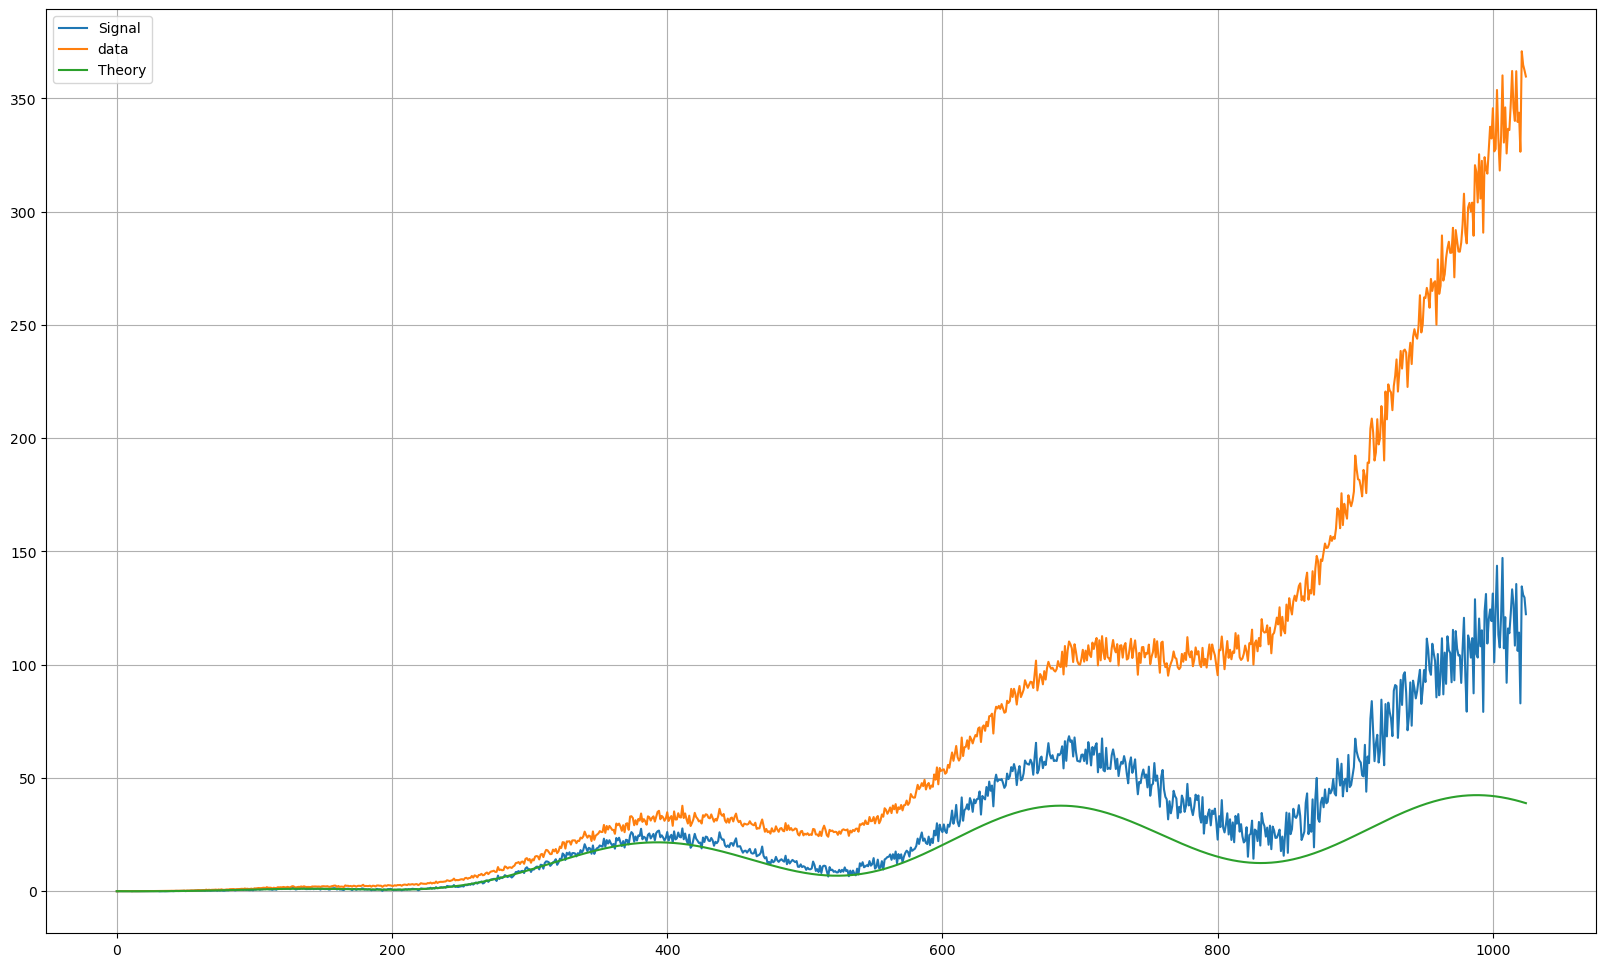

In [10]:
el = np.arange(1024+1)
plt.figure(figsize=(20,12))
plt.plot(el, el*(el+1)*signal[el]/ 2 / np.pi, label="Signal")
plt.plot(el, el*(el+1)*Dl[el]/ 2 / np.pi, label="data")
plt.plot(el, cl_th[el, 3], label="Theory")
plt.grid()

plt.legend()

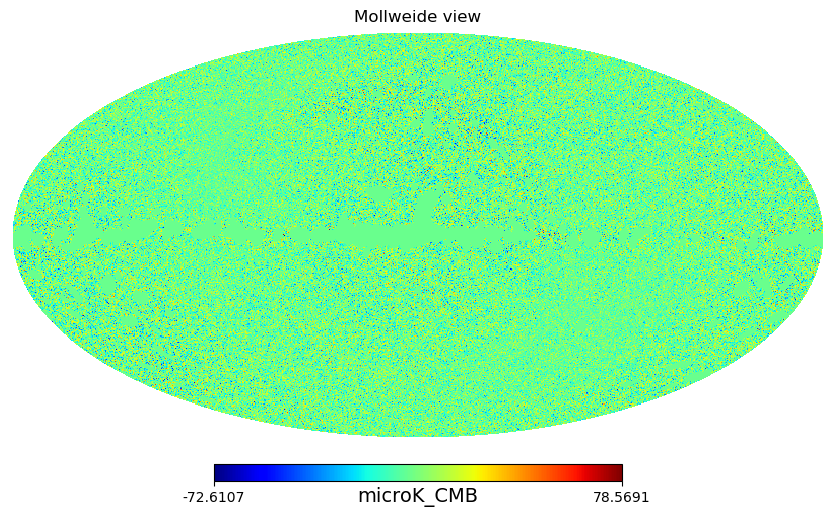

In [11]:
hp.mollview(map= emap*mask_p*1e6,
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            min=None, 
            max=None, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
#plt.savefig('map_beta10_value10_lmax512_nside512_newbps_2nd.png')